In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc  = (correct/len(y_pred)) * 100
    return acc

In [3]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, 
    centers=NUM_CLASSES, 
    cluster_std=1.5,
    random_state=RANDOM_SEED
)

In [4]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

In [5]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

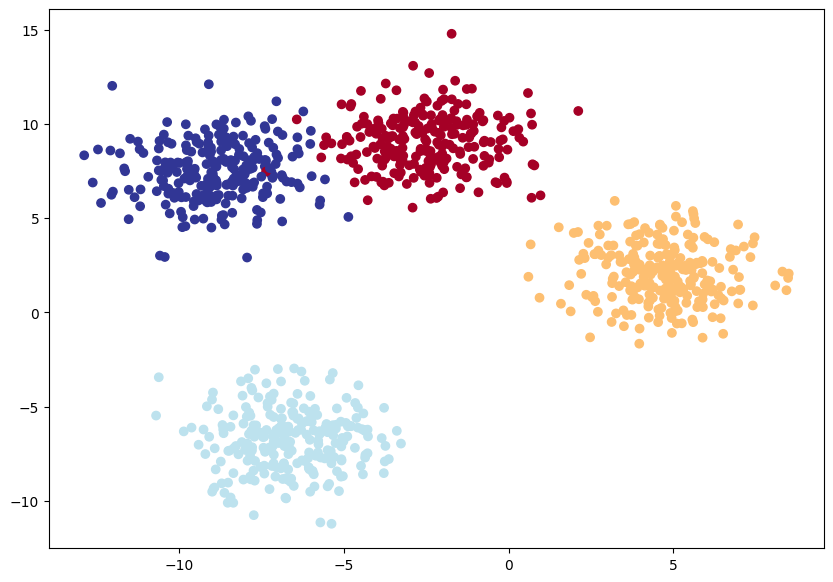

In [6]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {device}")

Training on cuda


In [8]:
x_blob_train = X_blob_train.to(device)
y_blob_train = y_blob_train.to(device)

x_blob_test = X_blob_test.to(device)
y_blob_test = y_blob_test.to(device)

In [9]:
class BlobModel(torch.nn.Module):
    
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = torch.nn.Sequential(
            
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)    
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [10]:
model_2 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_2

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [11]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [14]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):

    model_2.train()

    # 1. Forward pass
    y_logits = model_2(x_blob_train) 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train.long())  # Convert target to long
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_2(x_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test.long())  # Convert target to long
      test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.18388, Acc: 31.62% | Test Loss: 1.07520, Test Acc: 37.00%
Epoch: 10 | Loss: 0.58668, Acc: 93.62% | Test Loss: 0.51172, Test Acc: 96.00%
Epoch: 20 | Loss: 0.19349, Acc: 99.25% | Test Loss: 0.15797, Test Acc: 99.50%
Epoch: 30 | Loss: 0.09730, Acc: 99.50% | Test Loss: 0.07869, Test Acc: 99.50%
Epoch: 40 | Loss: 0.06637, Acc: 99.50% | Test Loss: 0.05247, Test Acc: 99.50%
Epoch: 50 | Loss: 0.05238, Acc: 99.50% | Test Loss: 0.04029, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04465, Acc: 99.50% | Test Loss: 0.03342, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03984, Acc: 99.50% | Test Loss: 0.02905, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03659, Acc: 99.50% | Test Loss: 0.02604, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03427, Acc: 99.38% | Test Loss: 0.02384, Test Acc: 99.50%


In [15]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


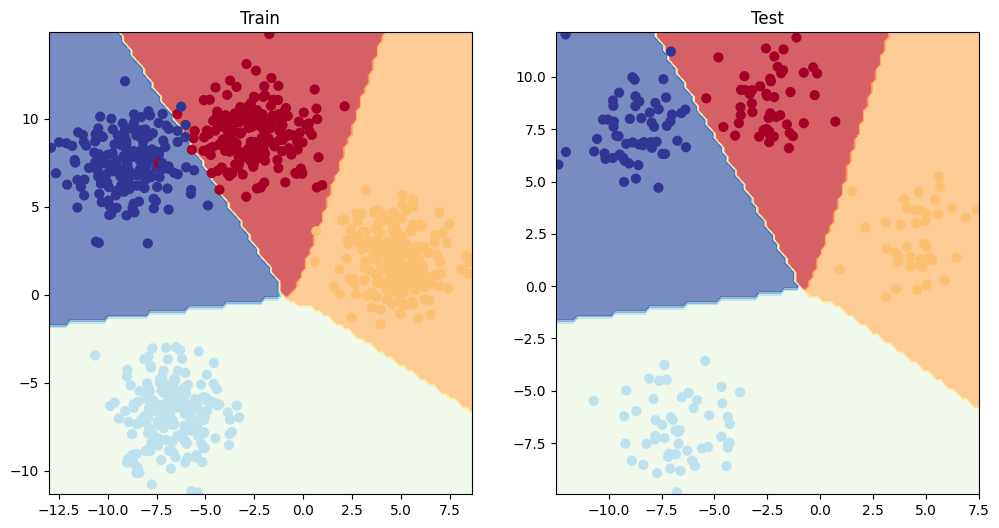

In [16]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_blob_test, y_blob_test)

In [17]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_logits = model_2(X_blob_test)


y_logits[:10]

tensor([[  3.5364,   8.9374,  -1.8437,  -3.3312],
        [  3.2089, -10.7346,   1.4524,   8.8461],
        [ -3.0006,  -2.7242,   5.1995,  -1.5305],
        [  1.4410,   5.5508,  -0.5049,  -2.3585],
        [  9.2924,   4.4025,  -4.9895,   0.1117],
        [  3.3884, -12.9460,   2.1213,  10.5966],
        [ -2.8091,  -2.3911,   5.0015,  -1.4216],
        [  8.6758,   0.8311,  -4.4338,   1.6430],
        [ -4.4815,  -3.7567,   6.9565,  -0.8995],
        [  8.7960,   2.1694,  -4.6392,   0.9964]])

In [21]:
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)
y_preds = y_preds.to(device)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.], device='cuda:0')
Test accuracy: 99.5%


In [22]:
from torchmetrics import Accuracy  

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

torchmetrics_accuracy(y_preds, y_blob_test)

c:\Users\chandula\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor(0.9950, device='cuda:0')